The code below is based on the tutorial - the structure should perhaps get encapsulated better later...

In [1]:
import klayout.db as db
import os
import numpy as np
from ClassLib import *

layout = db.Layout()
layout.dbu = 0.001 #This means that all numbers will be by reference in nm
if( layout.has_cell( "testScript") ):
    pass
else:
    cell = layout.create_cell( "testScript" )
layer_info_photo = db.LayerInfo(10,0)
layer_photo = layout.layer( layer_info_photo )

In [2]:
box = db.DBox(0, 0, 120, 250)
cell.shapes( layer_photo ).insert( box ) 

In [3]:
class CHIP:
    dx = 5.0e6 #7.75e6 #6.0e6## #length of the chip?
    dy = 2.1e6 #width of the chip? 7X2 mm
    L1 = 2.5e6 #what's this?
    gap = 150.e3 # the between CPW and ground?
    width = 260.e3 # of CPW?
    b = 2*gap + width
    origin = db.DPoint( 0,0 )
    box = db.DBox( origin, origin + db.DPoint( dx,dy ) )
    # only 4 connections programmed by now  ###what does the connection mean?
    connections = [box.p1 + db.DPoint( L1 + b/2,0 ), box.p1 + db.DPoint( dx - (L1+b/2),0 ), box.p2 - db.DPoint( L1 + b/2,0 ),  box.p1 + db.DPoint( L1 + b/2, dy )]

In [4]:
layer_info_photo = db.LayerInfo(10,0)
layer_info_el = db.LayerInfo(11,0)
layer_crosses = db.LayerInfo(2, 0)
layer_text = db.LayerInfo(3, 0)
layer_negative = db.LayerInfo(4, 0)
layer_photo = layout.layer( layer_info_photo )
layer_el = layout.layer( layer_info_el )
layer_cross = layout.layer(layer_crosses)
layer_txt = layout.layer(layer_text)
layer_neg = layout.layer(layer_negative)

In [5]:
N_repetitions = 1
Origin_list = [(0, n*(CHIP.dy))for n in range(N_repetitions)]
origins = Origin_list[0]
origin = db.DPoint( origins[0], origins[1] )
Origin_V = Vector( origins[0], origins[1] )
cell.shapes( layer_photo ).insert( db.Box( origin, Point( origins[0] + CHIP.dx, origins[1] + CHIP.dy ) ) )

In [6]:
# Draw crosses for reference

cross_small = 50e3
cross_small_neg = 100e3
cross_large = 500e3
cross_large_neg = 550e3

cross_ll = Cross( Origin_V + Vector(-(cross_large)/2, -(cross_large)/2), cross_small, cross_large )
cross_ll.place(cell, layer_cross)
cross_lr = Cross( Origin_V + Vector(CHIP.dx, 0)+ Vector(-(cross_large)/2, -(cross_large)/2 ), cross_small, cross_large )
cross_lr.place(cell, layer_cross)
cross_ul = Cross( Origin_V + Vector(0, CHIP.dy)+ Vector(-(cross_large)/2, -(cross_large)/2), cross_small, cross_large )
cross_ul.place(cell, layer_cross)
cross_lr = Cross( Origin_V + Vector(CHIP.dx, CHIP.dy)+ Vector(-(cross_large)/2, -(cross_large)/2 ), cross_small, cross_large )
cross_lr.place(cell, layer_cross)

#Negative crosses
cross_ll = Cross( Origin_V + Vector(-(cross_large_neg)/2, -(cross_large_neg)/2), cross_small_neg, cross_large_neg)
cross_ll.place(cell, layer_neg)
cross_lr = Cross( Origin_V + Vector(CHIP.dx, 0)+ Vector(-(cross_large_neg)/2, -(cross_large_neg)/2 ), cross_small_neg, cross_large_neg  )
cross_lr.place(cell, layer_neg)
cross_ul = Cross( Origin_V + Vector(0, CHIP.dy)+ Vector(-(cross_large_neg)/2, -(cross_large_neg)/2), cross_small_neg, cross_large_neg  )
cross_ul.place(cell, layer_neg)
cross_lr = Cross( Origin_V + Vector(CHIP.dx, CHIP.dy)+ Vector(-(cross_large_neg)/2, -(cross_large_neg)/2 ), cross_small_neg, cross_large_neg  )
cross_lr.place(cell, layer_neg)

## Main layer

Comment out "%%script false" to execute the cells.

### Gap Capacitors

In [7]:
#%%script false

# Dictionary of Chip Parameters
CPW_Magic_Ratio = 150/278.0  #Gap to Width
cpms={
    "Launch Pad Width"  : 260e3,
    "Launch Pad Gap"    : 150e3,
    "Launch Pad Length" : 500e3,
    
    "Launch to Capacitor"     : 750e3,

    "Capacitor Pre-Gap" : 84e3,
    "Capacitor Gap"     : 10e3,
    
    "Resonator Track Width" : 10e3,
    "Resonator Track Gap"   : 6.6e3,
    "Resonator Meander Radius"    : 105e3,
    "Resonator Meander Max Width" : 1.07e6
}

#Left contact pad
pad_L = CPW( cpms["Launch Pad Width"]*1.2, cpms["Launch Pad Gap"]*1.2,
             origin + DPoint( 0, CHIP.dy*0.5 ),
             origin + DPoint( cpms["Launch Pad Length"], CHIP.dy*0.5 ) )
pad_L.place( cell, layer_photo )


#Left Capacitor
#Padding
cap_L_pad = CPW( cpms["Resonator Track Width"], cpms["Resonator Track Gap"],
                 pad_L.end + DPoint(cpms["Launch to Capacitor"],0),
                 pad_L.end + DPoint(cpms["Launch to Capacitor"]+cpms["Capacitor Pre-Gap"],0) )
cap_L_pad.place( cell, layer_photo )
#Actual gap
cap_L = Capacitor_GapCPW(cap_L_pad.end, cap_L_pad, cpms["Capacitor Gap"], trans_in = klayout.db.Trans(3, False, 0, 0))
cap_L.place( cell, layer_photo )

#Connect Left contact pad to Capacitor
CPW2CPW( pad_L, cap_L_pad, pad_L.end, cap_L_pad.start ).place( cell, layer_photo )


#Resonator

#Meander resonator
res_mean = CPW_Meander_Resonator(cap_L.cpw_params, cap_L.end, 8.13e6,
                                 cpms["Resonator Meander Radius"], cpms["Resonator Meander Max Width"] )
res_mean.place(cell, layer_photo)


#Right Capacitor
#Actual gap
cap_R = Capacitor_GapCPW(res_mean.end, res_mean, cpms["Capacitor Gap"], trans_in = klayout.db.Trans(3, False, 0, 0))
cap_R.place( cell, layer_photo )
#Padding
cap_R_pad = CPW( cpms["Resonator Track Width"], cpms["Resonator Track Gap"],
                 cap_R.end,
                 cap_R.end + DPoint(cpms["Capacitor Pre-Gap"],0) )
cap_R_pad.place( cell, layer_photo )


#Right contact pad
pad_R = CPW( cpms["Launch Pad Width"]*1.2, cpms["Launch Pad Gap"]*1.2,
             cap_R_pad.end + DPoint(cpms["Launch to Capacitor"],0),
             DPoint(CHIP.dx, CHIP.dy/2) )
pad_R.place( cell, layer_photo )
#Connect Capacitor to Right contact pad
CPW2CPW( cap_R_pad, pad_R, cap_R_pad.end, pad_R.start ).place( cell, layer_photo )

layout.write(r'Example2_eric.gds')

### Fingered capacitors...

In [8]:
%%script false

# Dictionary of Chip Parameters
CPW_Magic_Ratio = 150/278.0  #Gap to Width
cpms={
    "Launch Pad Width"  : 260e3,
    "Launch Pad Gap"    : 150e3,
    "Launch Pad Length" : 500e3,
    
    "Launch to Capacitor"     : 750e3,

    "Capacitor Finger Number" : 4,
    "Capacitor Finger Length" : 100e3,
    "Capacitor Finger Width"  : 3.3e3,
    "Capacitor Finger Space"  : 3.3e3,   #Spacing between fingers
    
    "Capacitor to Resonator"  : 100e3,
    
    "Resonator Initial Pad" : 1e3,
    "Resonator Track Width" : 10e3,
    "Resonator Track Gap"   : 6.6e3,
    "Resonator Meander Radius"    : 105e3,
    "Resonator Meander Max Width" : 1.07e6
}

#Left contact pad
pad_L = CPW( cpms["Launch Pad Width"]*1.2, cpms["Launch Pad Gap"]*1.2,
             origin + DPoint( 0, CHIP.dy*0.5 ),
             origin + DPoint( cpms["Launch Pad Length"], CHIP.dy*0.5 ) )
pad_L.place( cell, layer_photo )

#Left Capacitor
#Assuming that capacitor has width equal to the CPW line - thus, the gaps around capacitor and connecting lines are the same
cap_width = cpms["Capacitor Finger Number"]*2*(cpms["Capacitor Finger Width"]+cpms["Capacitor Finger Space"])-cpms["Capacitor Finger Space"]
cap_side_gap = cap_width * CPW_Magic_Ratio
cap_padding = 5e3
cap_L = Capacitor_Interdigitated(pad_L.end + DPoint(cpms["Launch to Capacitor"],0),
                                 cpms["Capacitor Finger Width"],
                                 cpms["Capacitor Finger Space"],
                                 cpms["Capacitor Finger Length"],
                                 cpms["Capacitor Finger Space"], #Capacitor gap
                                 cap_padding,
                                 cap_side_gap,
                                 cpms["Capacitor Finger Number"],
                                 'same_N_right',
                                 trans_in = klayout.db.Trans(3, False, 0, 0))
cap_L.place( cell, layer_photo )

#Connect Left contact pad to Capacitor
CPW2CPW( pad_L, cap_L.cpw_params, pad_L.end, cap_L.start ).place( cell, layer_photo )

#Resonator

#Starting junction
res_start = CPW( cpms["Resonator Track Width"], cpms["Resonator Track Gap"],
                 cap_L.end + DPoint(cpms["Capacitor to Resonator"],0),
                 cap_L.end + DPoint(cpms["Capacitor to Resonator"]+cpms["Resonator Initial Pad"],0), CHIP.dy*0.5 )
res_start.place( cell, layer_photo )
#Connect Left Capacitor to start of Resonator
CPW2CPW( cap_L.cpw_params, res_start, cap_L.end, res_start.start ).place( cell, layer_photo )

#Meander resonator
res_mean = CPW_Meander_Resonator(res_start, res_start.end, 8.13e6,
                                 cpms["Resonator Meander Radius"], cpms["Resonator Meander Max Width"] )
res_mean.place(cell, layer_photo)

#Padding in end
res_end = CPW( cpms["Resonator Track Width"], cpms["Resonator Track Gap"],
                 res_mean.end,
                 res_mean.end + DPoint(cpms["Resonator Initial Pad"],0) )
res_end.place( cell, layer_photo )

#Right Capacitor
cap_R = Capacitor_Interdigitated(res_end.end + DPoint(cpms["Capacitor to Resonator"],0),
                                 cpms["Capacitor Finger Width"],
                                 cpms["Capacitor Finger Space"],
                                 cpms["Capacitor Finger Length"],
                                 cpms["Capacitor Finger Space"], #Capacitor gap
                                 cap_padding,
                                 cap_side_gap,
                                 cpms["Capacitor Finger Number"],
                                 'same_N_right',
                                 trans_in = klayout.db.Trans(3, False, 0, 0))
cap_R.place( cell, layer_photo )
#Connect Resonator to start of Right Capacitor
CPW2CPW( res_end, cap_R.cpw_params, res_end.end, cap_R.start ).place( cell, layer_photo )

#Right contact pad
pad_R = CPW( cpms["Launch Pad Width"]*1.2, cpms["Launch Pad Gap"]*1.2,
             cap_R.end + DPoint(cpms["Launch to Capacitor"],0),
             DPoint(CHIP.dx, CHIP.dy/2) )
pad_R.place( cell, layer_photo )
#Connect Capacitor to Right contact pad
CPW2CPW( cap_R.cpw_params, pad_R, cap_R.end, pad_R.start ).place( cell, layer_photo )

layout.write(r'Example2_eric.gds')

Couldn't find program: 'false'


## COMSOL simulation

The code above generates the geometry that is to be passed onto a fresh simulation built from scratch.

In [14]:
from ClassLib.COMSOL import COMSOL_Model

chip_len = CHIP.dx
chip_wid = CHIP.dy
chip_thickness = 0.5e-3

cmdl = COMSOL_Model('supercond',24)
cmdl.initialize_model(chip_len, chip_wid, chip_thickness)
#cmdl.save("D:\\WorkUQ\\COMSOL\\Goppl\\Res_Gap_8.13\\Test_1.mph")

In [15]:
cmdl.add_metallic_Klayout(layout, layer_photo)
cmdl.create_port_on_CPW(pad_L,True)
cmdl.create_port_on_CPW(pad_R,False)
#cmdl.save("D:\\WorkUQ\\COMSOL\\Goppl\\Res_Gap_8.13\\Test_1.mph")

In [ ]:
cmdl.register_fine_structure(res_mean.start*1e-9 + DPoint(1e-6,0), 1.2e-6, 10e-6)
cmdl.build_geom_mater_elec_mesh()
#cmdl.set_freq_range(7.212e9,7.215e9,20)
cmdl.set_freq_range(7.210e9,7.214e9,30)
cmdl.run_simulation()
cmdl.save("Test_1.mph")

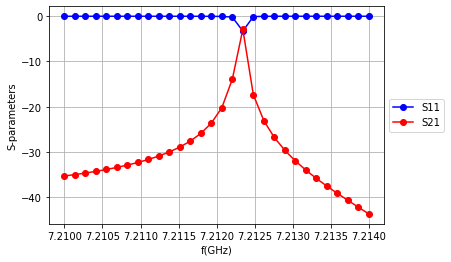

In [17]:
import matplotlib.pyplot as plt

s_param_vals = cmdl.get_sparams()
plt.plot(s_param_vals[0]/1e9, s_param_vals[1],'bo-',label='S11')
plt.plot(s_param_vals[0]/1e9, s_param_vals[2],'ro-',label='S21')
plt.grid(True, which="both")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('f(GHz)')
plt.ylabel('S-parameters')
plt.show()